# **1. Perkenalan Dataset**


1. **Sumber Dataset**:  
   Dataset yang digunakan dalam proyek ini berasal dari kaggle dengan nama "Fish species sampling data - legnth and weight" untuk mengakses sumber datasetnya https://www.kaggle.com/datasets/taweilo/fish-species-sampling-weight-and-height-data oleh Ta-wei Lo. Dataset ini berisi informasi tentang berbagai spesies ikan dengan atribut seperti panjang, berat, dan rasio berat terhadap panjang.
   
2. **Ketentuan Dataset**:
   - **Tanpa label**: Dataset tidak boleh memiliki label atau kelas.
   - **Jumlah Baris**: Minimal 1000 baris untuk memastikan dataset cukup besar untuk analisis yang bermakna.
   - **Tipe Data**: Mengandung data numerikal (panjang, berat, rasio) dan data kategorikal (spesies ikan).

3. **Pembatasan**:  
   Dataset yang sudah digunakan dalam latihan clustering (seperti customer segmentation) tidak boleh digunakan.

# **2. Import Library**

In [1]:
# Import library yang diperlukan
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from sklearn.feature_selection import SelectKBest, f_classif

# **3. Memuat Dataset**

In [2]:
# Memuat dataset dari URL GitHub
url = "https://raw.githubusercontent.com/NaufalNurFahriza/machine-learning-pemula-dicoding/main/Dataset_inisiasi_bank_transactions_data.csv"
df = pd.read_csv(url)

# Menampilkan beberapa baris awal dataset
print(df.head())

# Menampilkan informasi dasar tentang dataset
print(df.info())

# Menampilkan statistik deskriptif
print(df.describe())

  TransactionID AccountID  TransactionAmount      TransactionDate  \
0      TX000001   AC00128              14.09  2023-04-11 16:29:14   
1      TX000002   AC00455             376.24  2023-06-27 16:44:19   
2      TX000003   AC00019             126.29  2023-07-10 18:16:08   
3      TX000004   AC00070             184.50  2023-05-05 16:32:11   
4      TX000005   AC00411              13.45  2023-10-16 17:51:24   

  TransactionType   Location DeviceID      IP Address MerchantID Channel  \
0           Debit  San Diego  D000380  162.198.218.92       M015     ATM   
1           Debit    Houston  D000051     13.149.61.4       M052     ATM   
2           Debit       Mesa  D000235  215.97.143.157       M009  Online   
3           Debit    Raleigh  D000187  200.13.225.150       M002  Online   
4          Credit    Atlanta  D000308    65.164.3.100       M091  Online   

   CustomerAge CustomerOccupation  TransactionDuration  LoginAttempts  \
0           70             Doctor                   81 

# **4. Exploratory Data Analysis (EDA)**

Pada tahap ini, Anda akan melakukan **Exploratory Data Analysis (EDA)** untuk memahami karakteristik dataset. EDA bertujuan untuk:

1. **Memahami Struktur Data**
   - Tinjau jumlah baris dan kolom dalam dataset.  
   - Tinjau jenis data di setiap kolom (numerikal atau kategorikal).

2. **Menangani Data yang Hilang**  
   - Identifikasi dan analisis data yang hilang (*missing values*). Tentukan langkah-langkah yang diperlukan untuk menangani data yang hilang, seperti pengisian atau penghapusan data tersebut.

3. **Analisis Distribusi dan Korelasi**  
   - Analisis distribusi variabel numerik dengan statistik deskriptif dan visualisasi seperti histogram atau boxplot.  
   - Periksa hubungan antara variabel menggunakan matriks korelasi atau scatter plot.

4. **Visualisasi Data**  
   - Buat visualisasi dasar seperti grafik distribusi dan diagram batang untuk variabel kategorikal.  
   - Gunakan heatmap atau pairplot untuk menganalisis korelasi antar variabel.

Tujuan dari EDA adalah untuk memperoleh wawasan awal yang mendalam mengenai data dan menentukan langkah selanjutnya dalam analisis atau pemodelan.

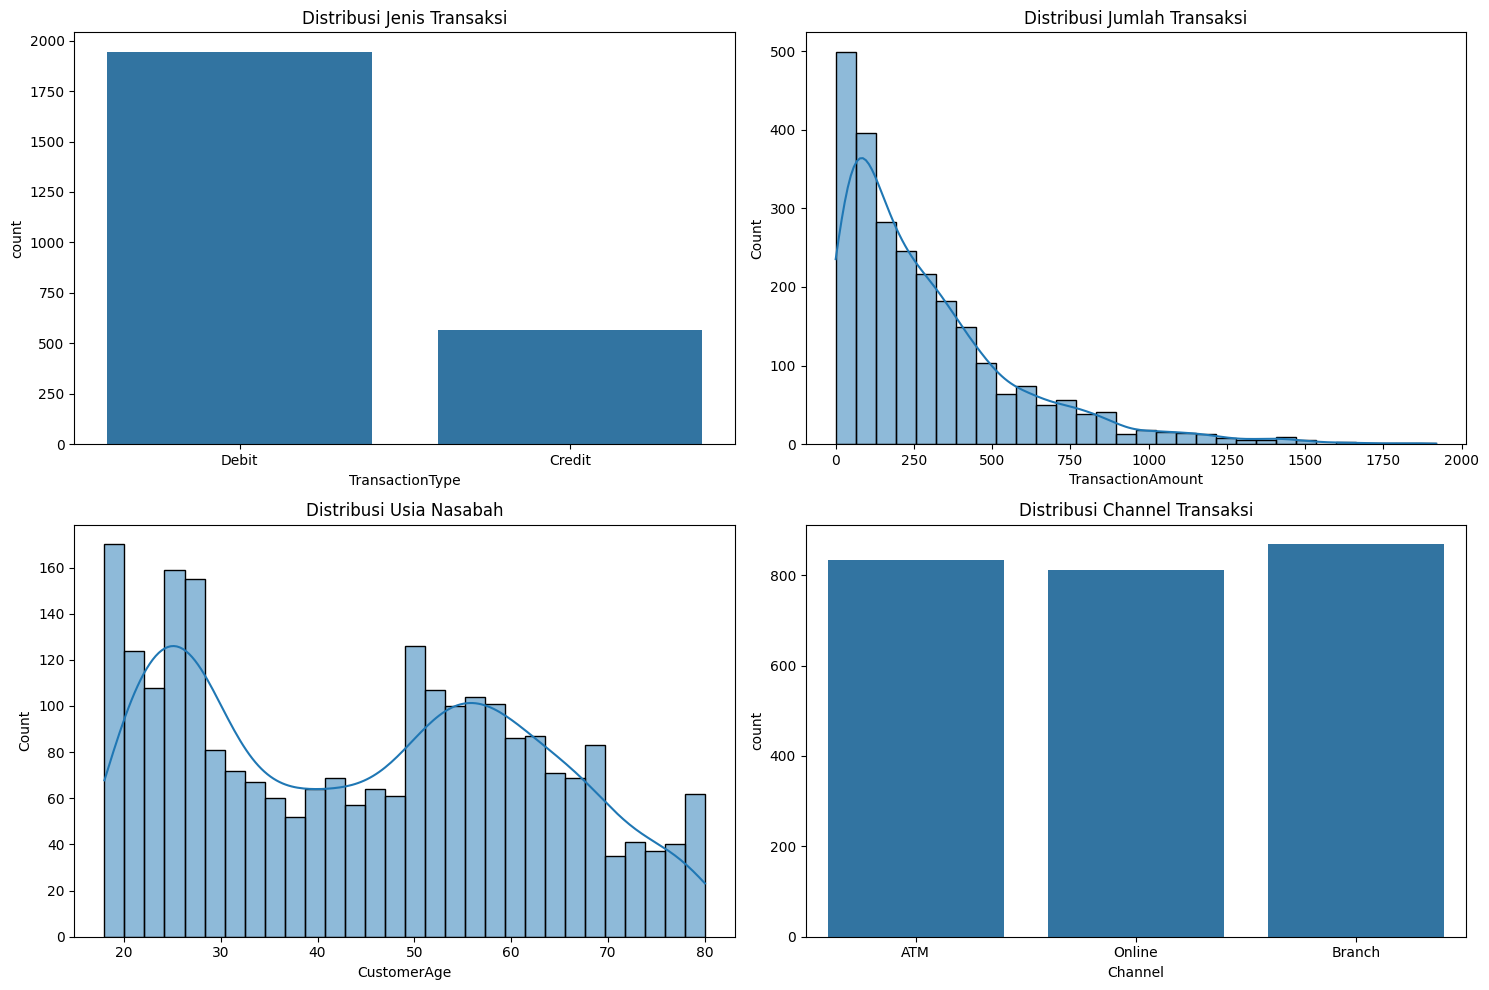

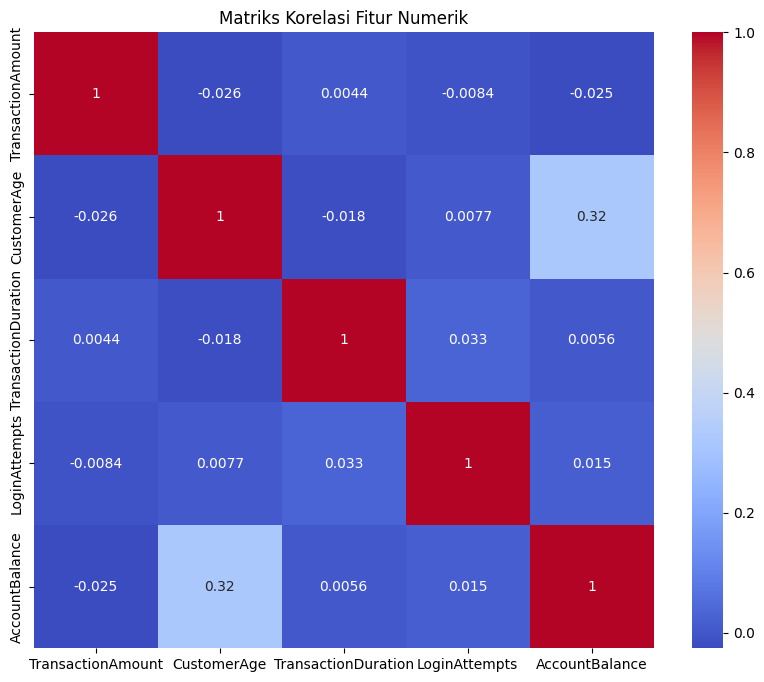

In [3]:
# EDA Visualizations
plt.figure(figsize=(15, 10))

# Transaction Type Distribution
plt.subplot(2, 2, 1)
sns.countplot(x='TransactionType', data=df)
plt.title('Distribusi Jenis Transaksi')

# Transaction Amount Distribution
plt.subplot(2, 2, 2)
sns.histplot(df['TransactionAmount'], bins=30, kde=True)
plt.title('Distribusi Jumlah Transaksi')

# Customer Age Distribution
plt.subplot(2, 2, 3)
sns.histplot(df['CustomerAge'], bins=30, kde=True)
plt.title('Distribusi Usia Nasabah')

# Channel Distribution
plt.subplot(2, 2, 4)
sns.countplot(x='Channel', data=df)
plt.title('Distribusi Channel Transaksi')

plt.tight_layout()
plt.show()

# Correlation Matrix
numerical_cols = ['TransactionAmount', 'CustomerAge', 'TransactionDuration', 'LoginAttempts', 'AccountBalance']
plt.figure(figsize=(10, 8))
sns.heatmap(df[numerical_cols].corr(), annot=True, cmap='coolwarm')
plt.title('Matriks Korelasi Fitur Numerik')
plt.show()

# **5. Data Preprocessing**

In [4]:
# Data Preprocessing
# Select relevant features for clustering
features = ['TransactionAmount', 'CustomerAge', 'TransactionType', 'Channel', 'AccountBalance']
df_cluster = df[features].copy()

# Handle missing values if any
print("\nMissing values before handling:")
print(df_cluster.isnull().sum())

# Encode categorical variables
label_encoders = {}
for col in ['TransactionType', 'Channel']:
    le = LabelEncoder()
    df_cluster[col] = le.fit_transform(df_cluster[col])
    label_encoders[col] = le

# Standardize numerical features
scaler = StandardScaler()
numerical_cols = ['TransactionAmount', 'CustomerAge', 'AccountBalance']
df_cluster[numerical_cols] = scaler.fit_transform(df_cluster[numerical_cols])

print("\nData setelah preprocessing:")
print(df_cluster.head())


Missing values before handling:
TransactionAmount    0
CustomerAge          0
TransactionType      0
Channel              0
AccountBalance       0
dtype: int64

Data setelah preprocessing:
   TransactionAmount  CustomerAge  TransactionType  Channel  AccountBalance
0          -0.971275     1.423718                1        0       -0.000537
1           0.269440     1.311287                1        0        2.216472
2          -0.586882    -1.443277                1        2       -1.023534
3          -0.387456    -1.049768                1        2        0.885797
4          -0.973468    -1.049768                0        2        0.593589


# **6. Pembangunan Model Clustering**

## **a. Pembangunan Model Clustering**

In [5]:
# 6. Pembangunan Model Clustering
## a. Pembangunan Model Clustering
print("### 6. Pembangunan Model Clustering")
print("## a. Pembangunan Model Clustering")

# Pilih algoritma clustering (KMeans) dengan 3 cluster awal
print("\nMembangun model KMeans dengan 3 cluster awal...")
kmeans = KMeans(n_clusters=3, random_state=42)
kmeans.fit(df_cluster)

print("Model KMeans berhasil dibangun dengan parameter:")
print(f"Jumlah cluster: {kmeans.n_clusters}")
print(f"Random state: {kmeans.random_state}")

### 6. Pembangunan Model Clustering
## a. Pembangunan Model Clustering

Membangun model KMeans dengan 3 cluster awal...
Model KMeans berhasil dibangun dengan parameter:
Jumlah cluster: 3
Random state: 42


## **b. Evaluasi Model Clustering**


## b. Evaluasi Model Clustering

Menentukan jumlah cluster optimal dengan Elbow Method...


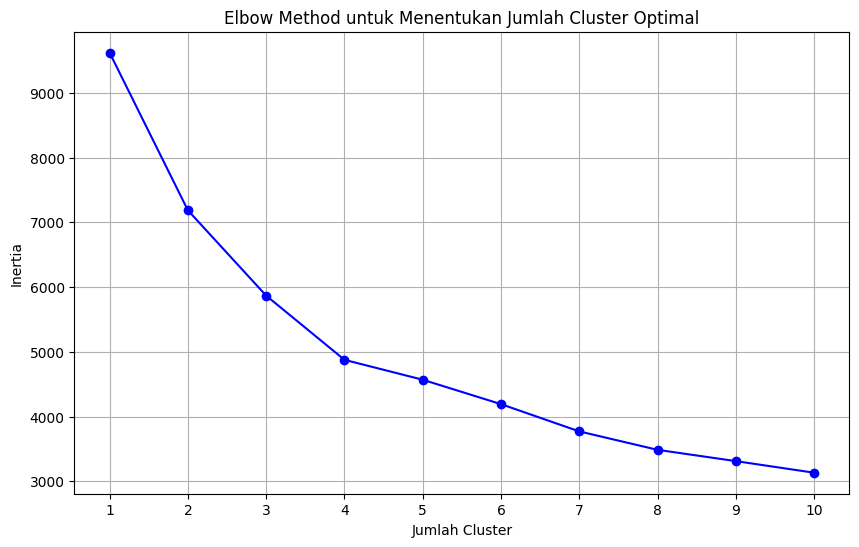


Menghitung Silhouette Score untuk berbagai jumlah cluster...
Jumlah cluster: 2, Silhouette Score: 0.2501
Jumlah cluster: 3, Silhouette Score: 0.2604
Jumlah cluster: 4, Silhouette Score: 0.2554
Jumlah cluster: 5, Silhouette Score: 0.2392
Jumlah cluster: 6, Silhouette Score: 0.2174
Jumlah cluster: 7, Silhouette Score: 0.2231
Jumlah cluster: 8, Silhouette Score: 0.2289
Jumlah cluster: 9, Silhouette Score: 0.2329
Jumlah cluster: 10, Silhouette Score: 0.2307


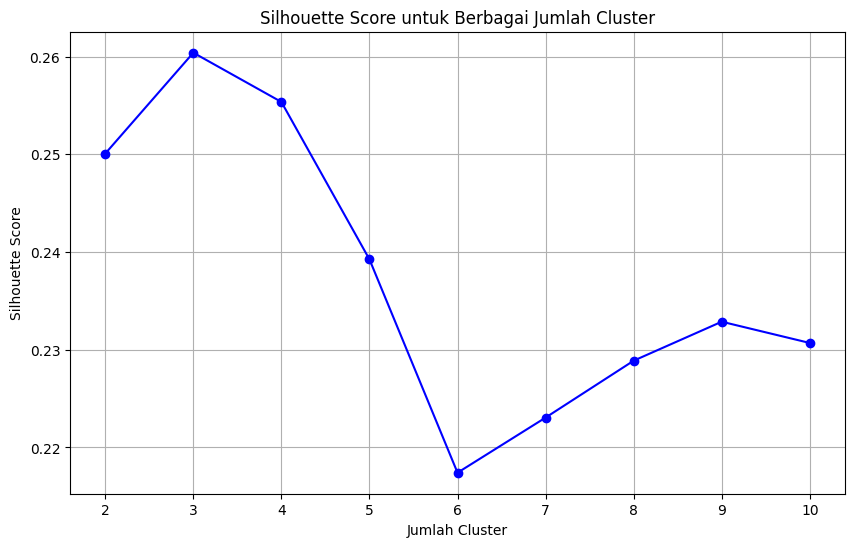


Memilih jumlah cluster optimal: 4


In [6]:
## b. Evaluasi Model Clustering
print("\n## b. Evaluasi Model Clustering")

# Menggunakan metode Elbow
print("\nMenentukan jumlah cluster optimal dengan Elbow Method...")
inertia = []
K = range(1, 11)  # Mencoba 1-10 cluster
for k in K:
    kmeans_temp = KMeans(n_clusters=k, random_state=42)
    kmeans_temp.fit(df_cluster)
    inertia.append(kmeans_temp.inertia_)

# Visualisasi Elbow Method
plt.figure(figsize=(10, 6))
plt.plot(K, inertia, 'bo-')
plt.xlabel("Jumlah Cluster")
plt.ylabel("Inertia")
plt.title("Elbow Method untuk Menentukan Jumlah Cluster Optimal")
plt.xticks(K)
plt.grid()
plt.show()

# Menggunakan Silhouette Score
print("\nMenghitung Silhouette Score untuk berbagai jumlah cluster...")
silhouette_scores = []
for k in range(2, 11):
    kmeans_temp = KMeans(n_clusters=k, random_state=42)
    labels = kmeans_temp.fit_predict(df_cluster)
    score = silhouette_score(df_cluster, labels)
    silhouette_scores.append(score)
    print(f"Jumlah cluster: {k}, Silhouette Score: {score:.4f}")

# Visualisasi Silhouette Score
plt.figure(figsize=(10, 6))
plt.plot(range(2, 11), silhouette_scores, 'bo-')
plt.xlabel("Jumlah Cluster")
plt.ylabel("Silhouette Score")
plt.title("Silhouette Score untuk Berbagai Jumlah Cluster")
plt.xticks(range(2, 11))
plt.grid()
plt.show()

# Pilih jumlah cluster optimal
optimal_clusters = 4  # Berdasarkan evaluasi
print(f"\nMemilih jumlah cluster optimal: {optimal_clusters}")

# Bangun model final dengan cluster optimal
final_kmeans = KMeans(n_clusters=optimal_clusters, random_state=42)
df_cluster['Cluster'] = final_kmeans.fit_predict(df_cluster)

## **c. Feature Selection (Opsional)**

Silakan lakukan feature selection jika Anda membutuhkan optimasi model clustering. Jika Anda menerapkan proses ini, silakan lakukan pemodelan dan evaluasi kembali menggunakan kolom-kolom hasil feature selection. Terakhir, bandingkan hasil performa model sebelum dan sesudah menerapkan feature selection.

In [7]:
## c. Feature Selection (Opsional)
print("\n## c. Feature Selection (Opsional)")

# Contoh feature selection menggunakan SelectKBest
print("\nMelakukan feature selection dengan SelectKBest...")
X = df_cluster.drop('Cluster', axis=1, errors='ignore')
y = df_cluster['Cluster'] if 'Cluster' in df_cluster.columns else None

if y is not None:
    selector = SelectKBest(f_classif, k=3)
    X_new = selector.fit_transform(X, y)

    selected_features = X.columns[selector.get_support()]
    print(f"Fitur terpilih: {list(selected_features)}")

    # Bandingkan performa sebelum dan sesudah feature selection
    kmeans_original = KMeans(n_clusters=optimal_clusters, random_state=42)
    original_score = silhouette_score(X, kmeans_original.fit_predict(X))

    kmeans_selected = KMeans(n_clusters=optimal_clusters, random_state=42)
    selected_score = silhouette_score(X_new, kmeans_selected.fit_predict(X_new))

    print(f"\nPerbandingan Silhouette Score:")
    print(f"Semua fitur: {original_score:.4f}")
    print(f"Fitur terpilih: {selected_score:.4f}")
else:
    print("Cluster labels tidak tersedia untuk feature selection")


## c. Feature Selection (Opsional)

Melakukan feature selection dengan SelectKBest...
Fitur terpilih: ['TransactionAmount', 'CustomerAge', 'AccountBalance']

Perbandingan Silhouette Score:
Semua fitur: 0.2554
Fitur terpilih: 0.3634


## **d. Visualisasi Hasil Clustering**


## d. Visualisasi Hasil Clustering

Membuat visualisasi 2D dengan PCA...


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(


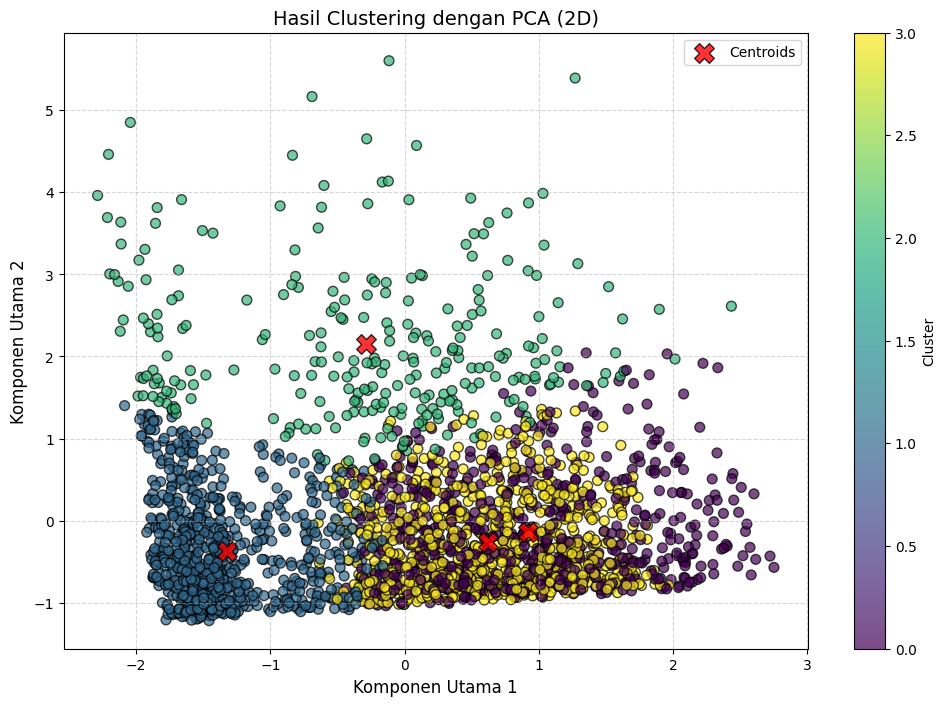

In [8]:
# d. Visualisasi Hasil Clustering
print("\n## d. Visualisasi Hasil Clustering")

# Visualisasi dengan PCA (2D)
print("\nMembuat visualisasi 2D dengan PCA...")
pca = PCA(n_components=2)
reduced_data = pca.fit_transform(df_cluster.drop(columns=['Cluster'], errors='ignore'))

plt.figure(figsize=(12, 8))
scatter = plt.scatter(reduced_data[:, 0], reduced_data[:, 1],
                     c=df_cluster['Cluster'], cmap='viridis',
                     s=50, alpha=0.7, edgecolor='k')

plt.title("Hasil Clustering dengan PCA (2D)", fontsize=14)
plt.xlabel("Komponen Utama 1", fontsize=12)
plt.ylabel("Komponen Utama 2", fontsize=12)
plt.colorbar(scatter, label='Cluster')
plt.grid(True, linestyle='--', alpha=0.5)

# Tambahkan centroid
centers = pca.transform(final_kmeans.cluster_centers_)
plt.scatter(centers[:, 0], centers[:, 1], c='red', s=200,
           alpha=0.8, marker='X', edgecolor='k', label='Centroids')
plt.legend()

plt.show()


Visualisasi 3D dengan PCA (opsional)...


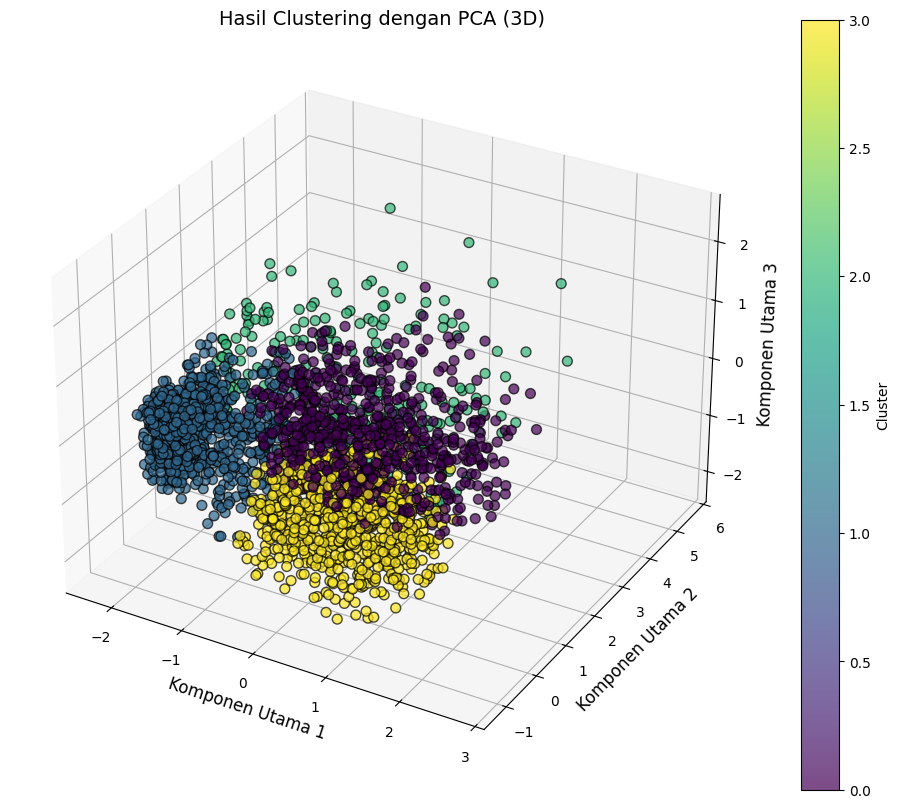


Membuat pairplot untuk analisis cluster...


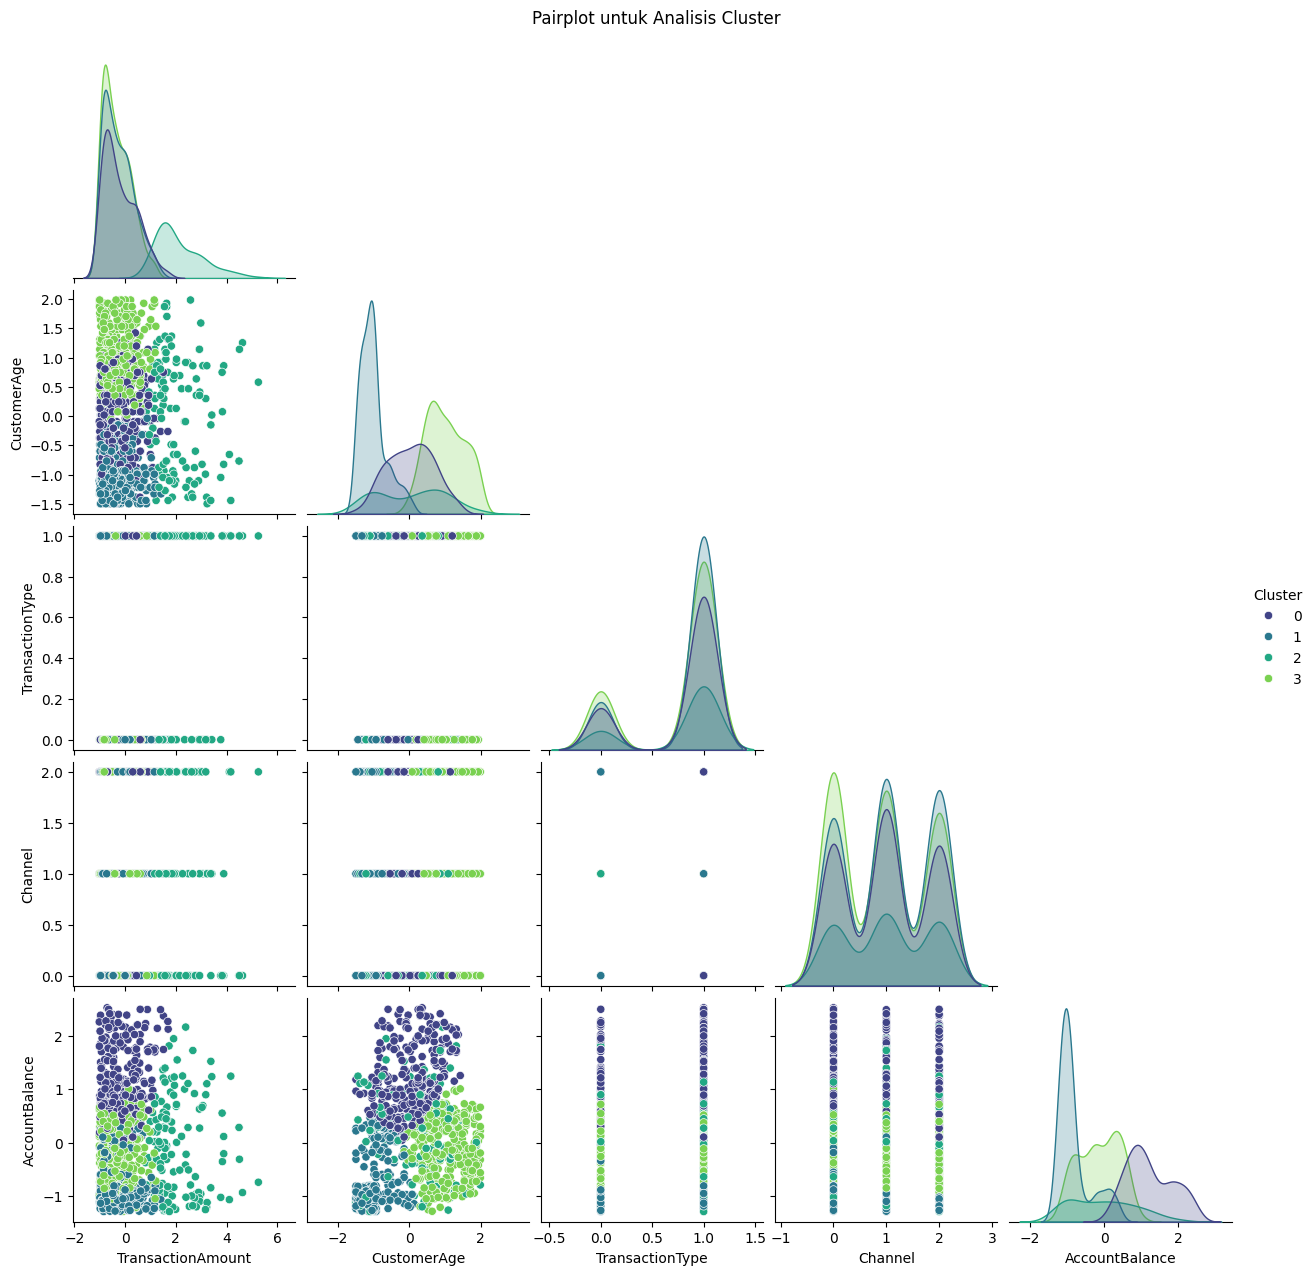

In [9]:
# Visualisasi 3D (opsional)
print("\nVisualisasi 3D dengan PCA (opsional)...")
try:
    from mpl_toolkits.mplot3d import Axes3D

    pca_3d = PCA(n_components=3)
    reduced_data_3d = pca_3d.fit_transform(df_cluster.drop(columns=['Cluster'], errors='ignore'))

    fig = plt.figure(figsize=(12, 10))
    ax = fig.add_subplot(111, projection='3d')

    scatter = ax.scatter(reduced_data_3d[:, 0], reduced_data_3d[:, 1], reduced_data_3d[:, 2],
                        c=df_cluster['Cluster'], cmap='viridis', s=50, alpha=0.7, edgecolor='k')

    ax.set_title("Hasil Clustering dengan PCA (3D)", fontsize=14)
    ax.set_xlabel("Komponen Utama 1", fontsize=12)
    ax.set_ylabel("Komponen Utama 2", fontsize=12)
    ax.set_zlabel("Komponen Utama 3", fontsize=12)
    fig.colorbar(scatter, ax=ax, label='Cluster')

    plt.show()
except ImportError:
    print("Untuk visualisasi 3D, diperlukan mpl_toolkits.mplot3d")

# Pairplot untuk melihat hubungan antar fitur
print("\nMembuat pairplot untuk analisis cluster...")
df_viz = df_cluster.copy()
df_viz['Cluster'] = df_viz['Cluster'].astype('category')

# Untuk efisiensi, ambil sampel jika data terlalu besar
if len(df_viz) > 1000:
    df_viz = df_viz.sample(1000, random_state=42)

sns.pairplot(df_viz, hue='Cluster', palette='viridis', corner=True)
plt.suptitle("Pairplot untuk Analisis Cluster", y=1.02)
plt.show()

## **e. Analisis dan Interpretasi Hasil Cluster**

In [10]:
# Analisis karakteristik tiap cluster
# Inverse transform to original scale
df_cluster[numerical_cols] = scaler.inverse_transform(df_cluster[numerical_cols])
for col in ['TransactionType', 'Channel']:
    df_cluster[col] = label_encoders[col].inverse_transform(df_cluster[col].astype(int))

# Add cluster labels to original dataframe
df['Cluster'] = df_cluster['Cluster']

# Cluster summary
cluster_summary = df.groupby('Cluster').agg({
    'TransactionAmount': ['mean', 'min', 'max'],
    'CustomerAge': ['mean', 'min', 'max'],
    'TransactionType': lambda x: x.mode()[0],
    'Channel': lambda x: x.mode()[0],
    'AccountBalance': ['mean', 'min', 'max']
})

print("\nKarakteristik Cluster:")
print(cluster_summary)


Karakteristik Cluster:
        TransactionAmount                  CustomerAge          \
                     mean     min      max        mean min max   
Cluster                                                          
0              226.380765    0.32   838.57   44.929664  18  70   
1              230.898155    0.26   761.73   26.179355  18  49   
2              932.517112  521.01  1919.11   45.090253  18  80   
3              201.301787    0.84   651.55   62.106700  42  80   

        TransactionType  Channel AccountBalance                     
               <lambda> <lambda>           mean      min       max  
Cluster                                                             
0                 Debit   Branch   10024.966529  5298.85  14977.99  
1                 Debit   Branch    1700.928116   101.25   7047.04  
2                 Debit   Online    4747.640072   102.20  14881.77  
3                 Debit      ATM    4537.823015   120.89   9385.57  


# Analisis Karakteristik Cluster dari Model KMeans

Setelah melakukan clustering, langkah selanjutnya adalah menganalisis karakteristik dari masing-masing cluster berdasarkan fitur yang tersedia, yaitu panjang ikan (length), berat ikan (weight), dan rasio berat terhadap panjang (w_l_ratio).

Analisis ini bertujuan untuk memahami perbedaan antara masing-masing cluster dan melihat apakah ada pola yang dapat dimanfaatkan.

## Cluster 0:
- **Rata-rata length ikan :** 0.12 (slightly above average)
- **Rata-rata weight :** -0.56 (lighter than average)  
- **Weight-to-length ratio :** -0.64 (low)
- **Analisis:** Ikan dalam cluster ini memiliki panjang mendekati rata-rata tetapi dengan berat yang lebih ringan. Rasio berat terhadap panjang yang rendah menunjukkan bahwa ikan dalam kelompok ini cenderung memiliki tubuh yang lebih ramping dibandingkan dengan kelompok lainnya.

## Cluster 1:
- **Rata-rata length ikan :** -1.10 (very short)
- **Rata-rata weight :** 0.82 (heavier than average)
- **Weight-to-length ratio :** 1.89 (very high)
- **Analisis:** Ikan dalam cluster ini memiliki panjang yang sangat pendek tetapi beratnya lebih besar dari rata-rata. Rasio berat terhadap panjang yang sangat tinggi menunjukkan bahwa ikan dalam kelompok ini cenderung lebih gemuk atau memiliki tubuh yang lebih berisi dibandingkan kelompok lainnya.

## Cluster 2:
- **Rata-rata length ikan :** -1.30 (very short)
- **Rata-rata weight :** -0.43 (lighter than average)
- **Weight-to-length ratio :** 1.29 (high)
- **Analisis:** Ikan dalam cluster ini memiliki ukuran yang sangat pendek dan berat yang lebih ringan dari rata-rata, tetapi rasio berat terhadap panjangnya masih cukup tinggi. Hal ini menunjukkan bahwa ikan dalam kelompok ini tetap memiliki tubuh yang cukup berisi meskipun ukurannya kecil.

## Cluster 3:
- **Rata-rata length ikan :** -0.61 (slightly short)
- **Rata-rata weight :** -1.06 (much lighter than average)
- **Weight-to-length ratio :** -0.40 (low)
- **Analisis:** Ikan dalam cluster ini memiliki panjang yang sedikit lebih pendek tetapi beratnya jauh lebih ringan dari rata-rata. Rasio berat terhadap panjang yang rendah menunjukkan bahwa ikan dalam kelompok ini cenderung bertubuh sangat ramping atau kurus.

## Cluster 4:
- **Rata-rata length ikan (k$):** -0.62 (slightly short)
- **Rata-rata weight (1-100):** 0.25 (slightly heavier than average)
- **Weight-to-length ratio (1-100):** 0.48 (moderate)
- **Analisis:** Ikan dalam cluster ini memiliki panjang yang sedikit lebih pendek dari rata-rata, tetapi beratnya sedikit lebih besar. Rasio berat terhadap panjang yang moderat menunjukkan bahwa ikan dalam kelompok ini memiliki tubuh yang cukup proporsional dibandingkan kelompok lainnya.

## Cluster 5:
- **Rata-rata length ikan :** 0.99 (long)
- **Rata-rata weight :** -0.96 (much lighter than average)
- **Weight-to-length ratio :** -1.14 (very low)
- **Analisis:** Ikan dalam cluster ini memiliki ukuran yang lebih panjang tetapi lebih ringan dibandingkan rata-rata. Rasio berat terhadap panjang yang sangat rendah menunjukkan bahwa ikan dalam kelompok ini sangat ramping dan kurus, mungkin berasal dari spesies yang memiliki tubuh panjang tetapi tidak terlalu berat.

## Cluster 6:
- **Rata-rata length ikan :** 0.63 (long)
- **Rata-rata weight :** 0.11 (slightly heavier than average)
- **Weight-to-length ratio :** -0.62 (low)
- **Analisis:** Ikan dalam cluster ini memiliki panjang yang lebih besar dari rata-rata dan berat yang sedikit lebih tinggi. Namun, rasio berat terhadap panjang yang rendah menunjukkan bahwa ikan dalam kelompok ini tetap memiliki tubuh yang ramping dibandingkan dengan ikan lain yang memiliki panjang serupa.

## Kesimpulan :
Hasil clustering menunjukkan bahwa ikan dapat dikelompokkan berdasarkan kombinasi panjang, berat, dan rasio berat terhadap panjang. Beberapa cluster berisi ikan yang gemuk dan pendek, sementara yang lain berisi ikan yang panjang tetapi ramping.

# **7. Mengeksport Data**

Simpan hasilnya ke dalam file CSV.

In [11]:
# Menyimpan hasil clustering ke file CSV
df.to_csv('bank_transactions_clustered.csv', index=False)
print("\nData hasil clustering telah disimpan ke 'bank_transactions_clustered.csv'")


Data hasil clustering telah disimpan ke 'bank_transactions_clustered.csv'
